### install pdftotext then download Meta earning transcript

In [ ]:
!pip install pdf2text
!wget https://s21.q4cdn.com/399680738/files/doc_financials/2023/q4/META-Q4-2023-Earnings-Call-Transcript.pdf
!pdf2txt.py META-Q4-2023-Earnings-Call-Transcript.pdf > META.txt

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:3 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,692 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,237 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Pac

### Install PySpark and create a SparkContext in local mode

In [ ]:
from pyspark.sql import SparkSession
spark  = SparkSession \
    .builder \
    .appName("NerdyWordCounting") \
    .master("local[*]") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext

From Spark 2.0 onwards, the Spark object is the unified entry point to a spark application (which grants access to a spark context, hive context, SQL context, etc). Prior to 2.0, the various contexts were created and managed independently. The Spark Web UI is accessible at
http://127.0.0.1:4040/

In [ ]:
sc

<SparkContext master=local[*] appName=NerdyWordCounting>


### Creating the RDD from File

Loading a file as a text file creates an RDD. We then cache this RDD. Frequently used RDDs should be cached to memory if possible. There are two methods to cache your data to memory: persist(storage_level) and cache(). The first time a persistence request is made, the RDD will get cached.

From the Spark API, the relevant options:

| Storage Level	| Meaning |
|:---|:---|
|MEMORY_ONLY|Store RDD as deserialized Java objects in the JVM. If the RDD does not <br>fit in memory, some partitions will not be cached and will be recomputed<br> on the fly each time they're needed. This is the default level.|
|MEMORY_AND_DISK|Store RDD as deserialized Java objects in the JVM. If the RDD does not<br> fit in memory, store the partitions that don't fit on disk, and read them<br> from there when they're needed.|
|DISK_ONLY|Store the RDD partitions only on disk.|
|MEMORY_ONLY_2,<br> MEMORY_AND_DISK_2, <br>etc.|Same as the levels above, but replicate each partition on two cluster nodes.|

The cache() method is a shortcut for calling persist(StorageLevel.MEMORY_ONLY).

In [ ]:
meta = sc.textFile(
    "META.txt",
    minPartitions=10).cache()

### Transformation: map()
The following map function is a transformation of the RDD and will simply add to the DAG that was created.

In [ ]:
# For each line in the META RDD apply the lambda function
stripped = meta.map(lambda line: line.strip())

# Print out the DAG - better would be to use the Web UI after an action
print(stripped.toDebugString().decode("utf-8"))

(10) PythonRDD[2] at RDD at PythonRDD.scala:53 []
 |   META.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0 []
 |   META.txt HadoopRDD[0] at textFile at NativeMethodAccessorImpl.java:0 []


### Transformation: filter()

In [ ]:
# Filter elements in the RDD that return True for the lambda function
stripped_Meta = stripped.filter(lambda line: line.find("Meta") != -1)

# Sample 10% of elements without replacement
sample = stripped_Meta.sample(False, 0.1)

### Action: take(), count() and collect()

In [ ]:
sample.take(5)

['But yes, I think Meta AI is going to be very important across the products. It']

In [ ]:
meta.count()

826

In [ ]:
sample.count()

1

In [ ]:
sample.collect()

['But yes, I think Meta AI is going to be very important across the products. It']

## Word count

In [ ]:
tmp = meta \
    .flatMap(lambda line: line.strip().split(" ")) \
    .filter(lambda word: word != "") \
    .map(lambda word: (word, 1))

In [ ]:
tmp.take(5)

[('Meta', 1), ('Platforms,', 1), ('Inc.', 1), ('(META)', 1), ('Fourth', 1)]

In [ ]:
counts = meta \
    .flatMap(lambda line: line.strip().split(" ")) \
    .filter(lambda word: word != "") \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)

In [ ]:
counts.take(10)

[('Quarter', 1),
 ('Results', 1),
 ('afternoon', 2),
 ('and', 262),
 ('I', 95),
 ('include', 1),
 ('forward‐looking', 3),
 ('Actual', 1),
 ('cause', 1),
 ('assumptions', 1)]

### Most common word - that's not a stop word

In [ ]:
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [ ]:
counts \
    .filter(lambda x: x[0].lower() not in stop_words) \
    .map(lambda x: (x[1], x[0])) \
    .sortByKey(ascending=False) \
    .first()

(53, 'AI')

### Most common word length

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

frequencies = counts \
    .filter(lambda x: x[0].lower() not in stop_words) \
    .map(lambda x: (len(x[0]), 1)) \
    .reduceByKey(lambda a, b: a + b) \
    .collect()

df = pd.DataFrame(frequencies, columns=["word_length", "word_count"])

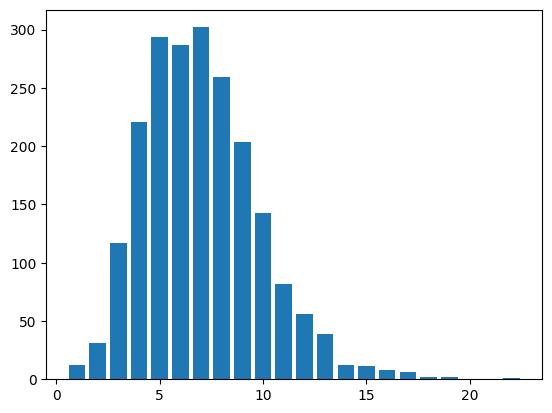

In [ ]:
plt.bar(x=df.word_length, height=df.word_count);

### Apply Loughran-McDonald Master Dictionary Dictionary-Based Sentiment Analysis
The [Loughran-McDonald Master Dictionary](https://sraf.nd.edu/loughranmcdonald-master-dictionary/) was initially developed in conjunction with our paper published in Journal of Finance (“When is a Liability not a Liability?, 2011). The dictionary provides a means of determining which tokens (collections of characters) are actual words, which is important for consistency in word counts. Within the dictionary spreadsheet we also provide flags for the sentiment dictionaries used in the JF paper (e.g., negative, uncertainty,
litigious).

In [ ]:
!wget -O dict.csv --no-check-certificate -r https://drive.google.com/uc?export=download\&id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik

will be placed in the single file you specified.

--2025-03-21 23:14:47--  https://drive.google.com/uc?export=download&id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik
Resolving drive.google.com (drive.google.com)... 142.250.153.102, 142.250.153.100, 142.250.153.139, ...
Connecting to drive.google.com (drive.google.com)|142.250.153.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik&export=download [following]
--2025-03-21 23:14:47--  https://drive.usercontent.google.com/download?id=17CmUZM9hGUdGYjCXcjQLyybjTrcjrhik&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.31.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8880507 (8.5M) [application/octet-stream]
Saving to: ‘dict.csv’

dict.csv        

In [ ]:
lmmd = pd.read_csv('dict.csv')
lmmd

,Word,Seq_num,Word Count,Word Proportion,Average Proportion,Std Dev,Doc Count,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Syllables,Source
0,AARDVARK,1,354,1.550080e-08,1.422600e-08,3.815486e-06,99,0,0,0,0,0,0,0,2,12of12inf
1,AARDVARKS,2,3,1.313627e-10,8.653817e-12,9.241714e-09,1,0,0,0,0,0,0,0,2,12of12inf
2,ABACI,3,9,3.940882e-10,1.169679e-10,5.290465e-08,7,0,0,0,0,0,0,0,3,12of12inf
3,ABACK,4,29,1.269840e-09,6.654735e-10,1.595100e-07,28,0,0,0,0,0,0,0,2,12of12inf
4,ABACUS,5,8570,3.752595e-07,3.809464e-07,3.529356e-05,1108,0,0,0,0,0,0,0,3,12of12inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86526,ZYGOTE,86529,50,2.189379e-09,8.729336e-10,1.886011e-07,35,0,0,0,0,0,0,0,2,12of12inf
86527,ZYGOTES,86530,1,4.378757e-11,1.809516e-11,1.932446e-08,1,0,0,0,0,0,0,0,2,12of12inf
86528,ZYGOTIC,86531,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf
86529,ZYMURGIES,86532,0,0.000000e+00,0.000000e+00,0.000000e+00,0,0,0,0,0,0,0,0,3,12of12inf


In [ ]:
lmmd_pos = lmmd.loc[lmmd.Positive>0]
lmmd_pos = set(lmmd_pos.Word)
lmmd_neg = lmmd.loc[lmmd.Negative>0]
lmmd_neg = set(lmmd_neg.Word)

In [ ]:
counts = meta \
    .flatMap(lambda line: line.strip().split(" ")) \
    .filter(lambda word: word != "") \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)
counts.take(10)

[('Quarter', 1),
 ('Results', 1),
 ('afternoon', 2),
 ('and', 262),
 ('I', 95),
 ('include', 1),
 ('forward‐looking', 3),
 ('Actual', 1),
 ('cause', 1),
 ('assumptions', 1)]

In [ ]:
counts_pos = meta \
    .flatMap(lambda line: line.strip().split(" ")) \
    .filter(lambda word: word != "") \
    .filter(lambda x : x.upper() in lmmd_pos) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)
poss = counts_pos.collect()
poss

[('efficiency', 5),
 ('best', 4),
 ('excited', 2),
 ('benefited', 1),
 ('achieve', 1),
 ('better', 7),
 ('solving', 1),
 ('leading', 3),
 ('optimistic', 1),
 ('opportunities', 2),
 ('enhancing', 1),
 ('stable', 1),
 ('enabling', 1),
 ('happy', 1),
 ('popular', 4),
 ('innovation', 2),
 ('advantages', 1),
 ('enables', 2),
 ('advancing', 1),
 ('enhanced', 1),
 ('stronger', 3),
 ('exciting', 7),
 ('improves', 3),
 ('Efficiency', 1),
 ('progress', 6),
 ('gains', 1),
 ('creative', 2),
 ('enable', 1),
 ('despite', 1),
 ('Good', 1),
 ('stability', 3),
 ('improvements', 9),
 ('enabled', 1),
 ('improving', 3),
 ('strong', 21),
 ('win', 1),
 ('progressing', 2),
 ('opportunity', 7),
 ('good', 13),
 ('efficient', 1),
 ('innovations', 1),
 ('valuable', 2),
 ('easier', 13),
 ('advantage', 1),
 ('improved', 3),
 ('easily', 2),
 ('improvement', 2),
 ('strength', 1),
 ('positive', 1),
 ('able', 4),
 ('improve', 6),
 ('succeeding', 1),
 ('friendly', 1),
 ('strongest', 2),
 ('pleased', 1),
 ('profitabilit

In [ ]:
sumposs = 0
for item in poss:
    sumposs = sumposs + item[1]
print(sumposs)

171


In [ ]:
counts = meta \
    .flatMap(lambda line: line.strip().split(" ")) \
    .filter(lambda word: word != "") \
    .filter(lambda x: x.upper() in lmmd_neg) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b)
negs = counts.collect()
negs

[('contesting', 1),
 ('seriously', 1),
 ('restructuring', 5),
 ('loss', 1),
 ('unpredictable', 1),
 ('layoffs', 1),
 ('adverse', 1),
 ('losses', 1),
 ('controversial', 1),
 ('questions', 4),
 ('question', 15),
 ('difficult', 1),
 ('unsuccessful', 1),
 ('volatile', 1)]

In [ ]:
sumnegs = 0
for item in negs:
    sumnegs = sumnegs + item[1]
print(sumnegs)

35


In [ ]:
sc.stop()

### Bonus Session: Python lambda functions
also known as anonymous functions, are small, inline functions that are defined without a name. They are typically used for short, simple operations where creating a full function using the def keyword would be overkill.

The syntax for a lambda function is:

`lambda arguments: expression`

Where arguments are the input parameters and expression is the computation to be performed. Lambda functions can take any number of arguments but can only have one expression.

Lambda functions are often used in conjunction with higher-order functions like map(), filter(), and reduce() to perform operations on iterables. They are also commonly used in situations where a function is needed as an argument to another function.

In [ ]:
def cube(x):
    return x*x*x

lambda_cube = lambda x: x*x*x

In [ ]:
cube(3)

27

In [ ]:
lambda_cube(3)

27

In [ ]:
numbers = [1, 2, 3, 4, 5]
doubled = list(map((lambda x: x * 2), numbers))
doubled

[2, 4, 6, 8, 10]

In [ ]:
numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
even = list(filter(lambda x: x % 2 == 0, numbers))
even

[2, 4, 6, 8, 10]

In [ ]:
lambda x: x>0, 0

(<function __main__.<lambda>(x)>, 0)

In [ ]:
print(lambda x: x>0, 0)

<function <lambda> at 0x7fed45368220> 0


In [ ]:
(lambda x: x if (x>0) else 0)(-1)

0

In [ ]:
(lambda x: x * x)(3)

9